# Weights & Biases Artifacts Time-to-live (TTL) Walkthrough
W&B Artifacts now supports setting time-to-live policies on each version of an Artifact. The feature is currently available in W&B SaaS Cloud and will be released to Enterprise customers using W&B Server in version 0.42.0. The following examples show the use TTL policy in a common Artifact logging workflow. We'll cover:

- Setting a TTL policy when creating an Artifact
- Retroactively setting TTL for a specific Artifact aliases
- Using the W&B API to set a TTL for all versions of an Artifact

# Setup
Let's do a few things before we get started. Below we will:

- Install the wandb and kaggle libraries (not pre-installed with Colab)
- Mount our GDrive so we can pass our kaggle credentials
- Create some working directories in our Colab session for storing our sample data

In [23]:
%%capture
!pip install wandb kaggle

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Kaggle Credentials
Here we copy our `kaggle.json` credentials from our GDrive to the working directory in Colab. Next we'll set the kaggle environment variables for this session.

In [25]:
import shutil
import json
import os

shutil.copy("/content/drive/MyDrive/kaggle.json", "/content/kaggle.json")

with open("/content/kaggle.json") as f:
    kaggle_json = json.load(f)

os.environ["KAGGLE_USERNAME"] = kaggle_json["username"]
os.environ["KAGGLE_KEY"] = kaggle_json["key"]


## Directory Setup and Dataset Download
We'll import some additional libraries for the walkthrough and create some folders to copy our sampled images to. For this demo we'll use the [CIFAKE dataset](https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images?resource=download) which is available from Kaggle.
*Make sure you import the kaggle library after you've copied your credentials to the Colab working directory.*

**References**

[Krizhevsky, A., & Hinton, G. (2009). Learning multiple layers of features from tiny images.](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdfl)

[Bird, J.J., Lotfi, A. (2023). CIFAKE: Image Classification and Explainable Identification of AI-Generated Synthetic Images. arXiv preprint arXiv:2303.14126.](https://arxiv.org/abs/2303.14126)

In [26]:
import wandb
import kaggle
import random
import numpy as np
from datetime import timedelta
import cv2

# %%capture
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images
!mkdir -p data
!mkdir -p data/sample/real
!mkdir -p data/sample/fake
!mkdir -p data/prepro/real
!mkdir -p data/prepro/fake
!unzip -n cifake-real-and-ai-generated-synthetic-images.zip -d data

cifake-real-and-ai-generated-synthetic-images.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  cifake-real-and-ai-generated-synthetic-images.zip


## Image Sampling
For the purposes of the walkthrough, let's sample from the larger CIFAR and CIFAKE training datasets and add them to a new folder in Colab. The block below:

- Creates folders for our sampled images
- Selects a random sample of images from the CIFAR/CIFAKE training data
- Copies the samples to our destination directories

*Note: we overwrite the files everytime we execute this so we get new Artifact versions.*

In [27]:
n_size = 100

real_source_dir = "data/train/REAL"
fake_source_dir = "data/train/FAKE"

real_sample_dir = "data/sample/real"
fake_sample_dir = "data/sample/fake"

real_images = [f for f in os.listdir(real_source_dir) if f.endswith((".jpg", ".jpeg", ".png", ".gif", ".bmp"))]
fake_images = [f for f in os.listdir(fake_source_dir) if f.endswith((".jpg", ".jpeg", ".png", ".gif", ".bmp"))]

real_sample = random.sample(real_images, n_size)
fake_sample = random.sample(fake_images, n_size)

def copy_images(image_ls, source_directory, sample_directory):
  # Remove the contents of the destination directory
  if os.path.exists(sample_directory):
      for item in os.listdir(sample_directory):
          item_path = os.path.join(sample_directory, item)
          if os.path.isfile(item_path):
              os.unlink(item_path)
          elif os.path.isdir(item_path):
              shutil.rmtree(item_path)
  for image in image_ls:
    source_path = os.path.join(source_directory, image)
    destination_path = os.path.join(sample_directory, image)
    shutil.copy(source_path, destination_path)

copy_images(real_sample, real_source_dir, real_sample_dir)
copy_images(fake_sample, fake_source_dir, fake_sample_dir)

## Image Preview
Quick block to view some of the images in the sampled dataset.

In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_sample_images(image_dir):
  # Get a list of image files in the directory
  image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]

  # Take the first 5 images (you can change the number if you want more or fewer)
  images_to_display = image_files[:5]

  # Create a figure with a grid layout to display the images
  fig, axes = plt.subplots(1, len(images_to_display), figsize=(15, 5))

  # Iterate over the images and display them
  for i, img_path in enumerate(images_to_display):
      img = mpimg.imread(img_path)
      axes[i].imshow(img)
      axes[i].axis('off')  # Turn off axis labels

  plt.tight_layout()
  plt.show()

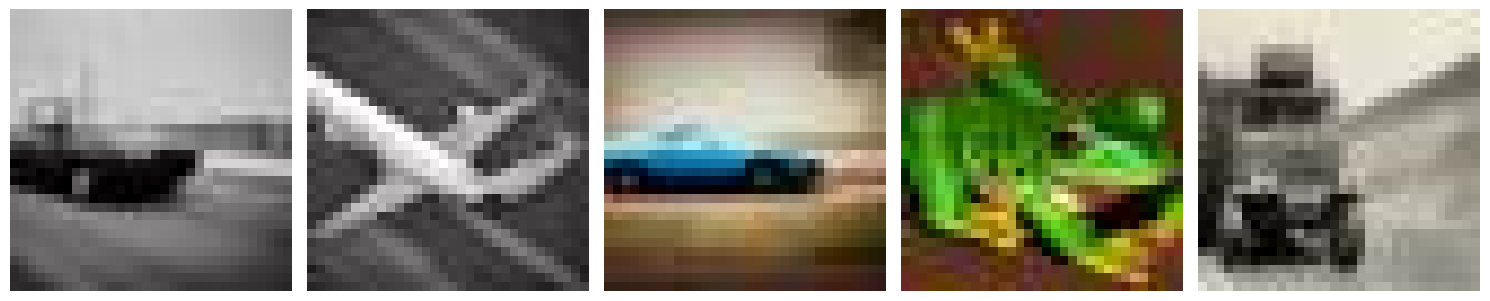

In [29]:
show_sample_images(fake_sample_dir)

# Setting TTL on New Artifacts
Below we create two new Artifacts for our real and fake data. Because we have internal retention policies in hypothetical organization we'd like to remove any Artifact that has real data (potentially containing personal data). Below we:

- Create a W&B Run to track the logging of these raw data Artifacts
- Set the ttl attribute on the real raw data
- Log our two Artifacts

In [30]:
with wandb.init(entity="wandb-smle", project="artifacts-ttl-demo", job_type="raw-data") as run:
  raw_real_art = wandb.Artifact(
      "real-raw", type="dataset",
      description="Raw sample images from CIFAR"
  )

  raw_real_art.add_dir(real_sample_dir)
  raw_real_art.ttl = timedelta(days=10)
  run.log_artifact(raw_real_art)

  raw_fake_art = wandb.Artifact(
      "fake-raw", type="dataset",
      description="Raw sample images from Bird and Lofti (2023)"
  )

  raw_fake_art.add_dir(fake_sample_dir)
  run.log_artifact(raw_fake_art)

  run.finish()

wandb: Adding directory to artifact (./data/sample/real)... Done. 0.2s
wandb: Adding directory to artifact (./data/sample/fake)... Done. 0.1s


# Updating/Retroactively Setting TTL on Artifacts
In our hypothetical organization we've been given approval to retain a specific version of our data indefinitely. We've also been given approval to extend the retention date of an additional dataset. Below we'll:

- Extend the TTL of an Artifact tagged with the `extended` alias
- Remove the TTL of an Artifact tagged with the `compliant` alias
- Programmatically check the status of these two Artifacts

In [31]:
with wandb.init(entity="wandb-smle", project="artifacts-ttl-demo", job_type="modify-ttl") as run:
  extended_art = run.use_artifact("wandb-smle/artifacts-ttl-demo/real-raw:extended")
  extended_art.ttl = timedelta(days=365)  # Delete in a year
  extended_art.save()

  compliant_art = run.use_artifact("wandb-smle/artifacts-ttl-demo/real-raw:compliant")
  compliant_art.ttl = None
  compliant_art.save()

  print(extended_art.ttl)
  print(compliant_art.ttl)

  run.finish()

365 days, 0:00:00
None


# Use W&B Import/Export API to Iterate Artifact Versions and Set TTL
Let's say we've received approval to retain all of the data within a given Artifact and we'd like to remove all TTL policies for every version of an Artifact. Below we:

- Use the W&B API to get a list of all Runs in a project
- Get a list of all versions of a specific Artifact (e.g. `fake-raw`)
- Iterate over each  version and remove any existing TTL policy associated with the version

In [32]:
# Artifact metadata extraction
api = wandb.Api()

# Define entity and project
entity, project = "wandb-smle", "artifacts-ttl-demo"

runs = api.runs(entity + "/" + project)

version_names = []
for run in runs:
    for artifact in iter(run.logged_artifacts()):
        if "fake-raw" in artifact.name:
          # Can be edited to just display individual elements
          version_names.append(f"{artifact.name}/{artifact.version}")

with wandb.init(entity="wandb-smle", project="artifacts-ttl-demo", job_type="modify-ttl") as run:
  for version in version_names:
    version_art = run.use_artifact(f"wandb-smle/artifacts-ttl-demo/{'/'.join(version.split('/')[:-1])}")
    version_art.ttl = None
    version_art.save()
    print(version_art.ttl)


None
None
None
None
None
None
None
None
None
None
None
None


# Traverse an Artifact Graph to Set Downstream TTL
In this last section, we'll do some preprocessing on our images and log those as downstream Artifacts. Once again we'll use the W&B Import/Export API to set a TTL policy on our downstream images for images that originated from our "real" dataset.

## Preprocess and log a new Artifact

In [33]:
real_prepro_dir = "data/prepro/real"
fake_prepro_dir = "data/prepro/fake"

def preprocess_image(image_path):
  """Preprocesses an image by resizing it to 256x256, normalizing it to [0, 1], and flipping it horizontally with 50% probability."""
  image = cv2.imread(image_path)
  image = cv2.resize(image, (256, 256))
  image = cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX)
  if np.random.random() > 0.5:
    image = cv2.flip(image, 1)
  return image

with wandb.init(entity="wandb-smle", project="artifacts-ttl-demo", job_type="preprocessing") as run:
  real_art = run.use_artifact("wandb-smle/artifacts-ttl-demo/real-raw:latest")
  real_images = real_art.download()

  for image_file in os.listdir(real_images):
    image_path = os.path.join(real_images, image_file)
    preprocessed_image = preprocess_image(image_path)
    cv2.imwrite(os.path.join("data/prepro/real/", image_file), preprocessed_image)

  prepro_real_art = wandb.Artifact(
      "real-prepro", type="dataset",
      description="Preprocessed images from CIFAR"
  )

  prepro_real_art.add_dir(real_prepro_dir)
  run.log_artifact(prepro_real_art)
  run.finish()

wandb:   100 of 100 files downloaded.  
wandb: Adding directory to artifact (./data/prepro/real)... Done. 0.1s


## Traverse the Artifact Graph and Set TTL
Let's take a look at the original real dataset and traverse downstream runs and Artifacts to set a TTL policy on anything that originated from the real dataset.

In [34]:
api = wandb.Api()

# For demo purposes we'll just do this on the latest version of the real dataset
artifact = api.artifact("wandb-smle/artifacts-ttl-demo/real-raw:latest")
consumer_runs = artifact.used_by()

# Same pattern from above to get all downstream versions
version_names = []
for run in consumer_runs:
    for artifact in iter(run.logged_artifacts()):
        # filter for datasets only
        if artifact.type == "dataset":
          # Can be edited to just display individual elements
          version_names.append(f"{artifact.name}/{artifact.version}")

with wandb.init(entity="wandb-smle", project="artifacts-ttl-demo", job_type="modify-ttl") as run:
  for version in version_names:
    version_art = run.use_artifact(f"wandb-smle/artifacts-ttl-demo/{'/'.join(version.split('/')[:-1])}")
    # set ttl to a random integer so we can see changes in the UI after we run this
    version_art.ttl = timedelta(days=random.randint(1,100))
    version_art.save()
    run.finish()